In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.pyplot import plot as plt
import timeit

In [ ]:
#Data

#BT Thermal
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_BT_Heat_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_BT_Heat_Rate.csv'

#GF Immersion
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_Geroge_Fox_Immersion_Heat(KWh)_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_Immersion_Heat(KWh)_Rate.csv'

# Temperature
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_George_Fox_temp(DegC).csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_temp(DegC).csv'

#GF B27 Thermal
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_George_Fox_Thermal(KWh)_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_Thermal(KWh)_Rate.csv'

# BT Oc
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/BT_Oc_Train.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/BT_Oc_Test.csv'

# Library Oc
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Library_Train.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Library_Test.csv'

train = pd.read_csv(filepath1)
test = pd.read_csv(filepath2)
train.head()

,time,Associated Client Count
0,2018-08-20 00:00:00,33
1,2018-08-20 01:00:00,37
2,2018-08-20 02:00:00,38
3,2018-08-20 03:00:00,33
4,2018-08-20 04:00:00,36


In [ ]:
#Specific Data Manipulation
train.columns = ['timestamp','reading']
test.columns = ['timestamp','reading']
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)
train.set_index('timestamp', inplace=True)
test.set_index('timestamp', inplace=True)
#train = train.resample('1H').asfreq()
#test = test.resample('1H').asfreq()
#train = train.resample('1H').sum()
#test = test.resample('1H').sum()
train.dropna(inplace=True)
test.dropna(inplace=True)
train.tail()

,reading
timestamp,
2019-12-09 19:00:00,26992
2019-12-09 20:00:00,25062
2019-12-09 21:00:00,21944
2019-12-09 22:00:00,15728
2019-12-09 23:00:00,13128


In [ ]:
#Preprocessing
def LSTM_dataprep(data, n_in, n_out):
    length = n_in+n_out
    count = 0
    X, y = [], []
    for x in range(len(data) - length):
        dat = data[count:(count+length)]
        valin = dat[:n_in]
        valout = dat[n_in:]
        X.append(valin)
        y.append(valout)
        count+=1
    return np.array(X), np.array(y)

def reshape_Inputs(train_X, test_X): #Reshapes inputs into the 3D input required by the LSTM
    train_X.shape = (train_X.shape[0], train_X.shape[1], 1)
    test_X.shape = (test_X.shape[0], test_X.shape[1], 1)
    return train_X, test_X

def scaler(train_X, train_y): #Scales the input before feeding to the neural network 
  scaler = MinMaxScaler(feature_range=(0, 1))
  
  txs = scaler.fit(train_X)
  train_X = txs.transform(train_X)
  tys = scaler.fit(train_y)
  train_y = tys.transform(train_y)
  return train_X, train_y, txs, tys

#Variables
size_in = 366
size_out = 48

#Implementation
train_X, train_y = LSTM_dataprep(train, size_in, size_out)
test_X, test_y = LSTM_dataprep(test, size_in, size_out)
train_X = train_X[:,:,0]
train_y = train_y[:,:,0]
test_X = test_X[:,:,0]
train_X, train_y, train_X_scaler, train_y_scaler = scaler(train_X, train_y)
train_X, test_X= reshape_Inputs(train_X, test_X)
train_X, val_X = train_test_split(train_X, test_size=0.05, shuffle=False)
train_y, val_y = train_test_split(train_y, test_size=0.05, shuffle=False)

In [ ]:
#Optimising
results = []
#Hyperparameters
units = [20, 50, 100, 200]
batch_size = [20, 50, 100, 200]

#Grid Search Implementation
for x in units:
  for y in batch_size:
    #Model
    model = Sequential()
    model.add(LSTM(units=x, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(BatchNormalization())
    #model.add(LSTM(units=x, return_sequences=True))
    #model.add(BatchNormalization())
    #model.add(LSTM(units=x))
    #model.add(BatchNormalization())
    model.add(Dense(size_out))

    early_stopping = EarlyStopping(min_delta=0.001, patience=5, mode='min', restore_best_weights=True)
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='mae')

    #Training
    history = model.fit(train_X[-500:], train_y[-500:], validation_data=(val_X, val_y), batch_size=y, epochs=600, callbacks=[early_stopping])

    #Recording for search pass 
    valloss = history.history.get('val_loss')
    error = min(valloss)
    record = {'units':x, 'batch_size':y, 'layers':3, 'mae':error}
    results.append(record)

Epoch 1/600
25/25 [==============================] - 52s 108ms/step - loss: 0.1264 - val_loss: 0.0796
Epoch 2/600
25/25 [==============================] - 2s 91ms/step - loss: 0.0754 - val_loss: 0.0779
Epoch 3/600
25/25 [==============================] - 2s 95ms/step - loss: 0.0599 - val_loss: 0.0770
Epoch 4/600
25/25 [==============================] - 2s 92ms/step - loss: 0.0559 - val_loss: 0.0754
Epoch 5/600
25/25 [==============================] - 2s 93ms/step - loss: 0.0543 - val_loss: 0.0742
Epoch 6/600
25/25 [==============================] - 2s 93ms/step - loss: 0.0541 - val_loss: 0.0737
Epoch 7/600
25/25 [==============================] - 2s 92ms/step - loss: 0.0539 - val_loss: 0.0728
Epoch 8/600
25/25 [==============================] - 2s 94ms/step - loss: 0.0540 - val_loss: 0.0717
Epoch 9/600
25/25 [==============================] - 2s 94ms/step - loss: 0.0538 - val_loss: 0.0713
Epoch 10/600
25/25 [==============================] - 2s 93ms/step - loss: 0.0535 - val_loss: 0.07

In [ ]:
#Output from GridSearch
threelayers = pd.DataFrame.from_dict(results) #Needs to be manually saved each time into variables 'onelayer', 'twolayers' and 'threelayers'

In [ ]:
#Compiling Grid Search
comparison = onelayer.append(twolayers, ignore_index=True)
comparison = comparison.append(threelayers, ignore_index=True)
comparison.to_csv('/content/drive/MyDrive/Colab Notebooks/Grid Search Results Temperature/LSTM_GridSearch_Temperature')
comparison

,units,batch_size,layers,mae
0,20,20,1,0.136645
1,20,50,1,0.116635
2,20,100,1,0.112712
3,20,200,1,0.150423
4,50,20,1,0.106478
5,50,50,1,0.117296
6,50,100,1,0.122679
7,50,200,1,0.138369
8,100,20,1,0.103218
9,100,50,1,0.104415


In [ ]:
start = timeit.default_timer()

#Training Optimum Model
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(units=100, input_shape=(train_X.shape[1], train_X.shape[2])))
LSTMmodel.add(BatchNormalization())
LSTMmodel.add(Dense(size_out))

early_stopping = EarlyStopping(min_delta=0.001, patience=5, mode='min', restore_best_weights=True)
opt = keras.optimizers.Adam()
LSTMmodel.compile(optimizer=opt, loss='mae')

#Training
LSTMhistory = LSTMmodel.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=20, epochs=600, callbacks=[early_stopping])

stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/600
525/525 [==============================] - 9s 15ms/step - loss: 0.0975 - val_loss: 0.1695
Epoch 2/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0849 - val_loss: 0.1101
Epoch 3/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0822 - val_loss: 0.1027
Epoch 4/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0816 - val_loss: 0.1036
Epoch 5/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0814 - val_loss: 0.1041
Epoch 6/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0816 - val_loss: 0.1131
Epoch 7/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0807 - val_loss: 0.1035
Epoch 8/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0808 - val_loss: 0.1002
Epoch 9/600
525/525 [==============================] - 7s 14ms/step - loss: 0.0790 - val_loss: 0.1030
Epoch 10/600
525/525 [==============================] - 7s 14ms/step - loss: 0.080

In [ ]:
#Save model
LSTMmodel.save('/content/drive/MyDrive/Colab Notebooks/Saved Temperature Models/LSTM_Temperature_Model')

#Load Model
#LSTMmodel = load_model('/content/drive/MyDrive/Colab Notebooks/Saved Thermal Models/LSTM_Thermal_Model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Saved Temperature Models/LSTM_Temperature_Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Saved Temperature Models/LSTM_Temperature_Model/assets


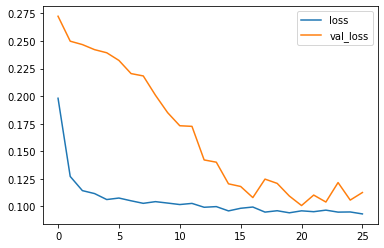

In [ ]:
#Plotting loss curves
history_dat = pd.DataFrame(LSTMhistory.history)
history_dat.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
#Testing
def averageMAE(true, preds):
    ae = [0]*len(preds)
    for x in range(len(preds)):
      ae[x] = mean_absolute_error(true[x], preds[x])
    return (sum(ae))/len(preds)

def predict(model, test):
  #scaling
  scaler_test = MinMaxScaler(feature_range=(0, 1))
  output = []
  for f in range(test.shape[0]):
    t = test[f]
    texs = scaler_test.fit(t)
    inp = texs.transform(t)

    #Shape
    inp.shape = (-1, inp.shape[0], inp.shape[1])

    #Predictions
    prediction = LSTMmodel.predict(inp)
    prediction.shape = (prediction.shape[1], 1)

    #Inverse Transform
    pred = texs.inverse_transform(prediction)
    pred = np.array(pred)
    output.append(pred)
  return output

def testing(predictions, val):
    maeSet = []
    for z in range(len(predictions)):
      mae = averageMAE(predictions[z], val[z])
      maeSet.append(mae)
    return maeSet

#Implementation
output = predict(LSTMmodel, test_X[-10:])
final = testing(output, test_y[-10:])
final = pd.DataFrame(final)
final.describe()

,0
count,10.000000
mean,1617.365965
std,266.064173
min,1207.767757
25%,1396.725858
50%,1712.026280
75%,1833.316509
max,1898.920592


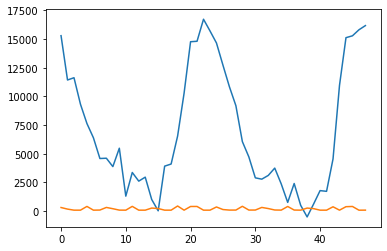

In [ ]:
#Visualising 
plt(output[2])
plt(test_y[2])